In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
# 设置__package__
# 当执行notebook时，python编译器认为它自身是主模块，即__name__='main'，无父包，即__package__=None
# 当__package__=None时，是无法做相对引用的，即如 from .mm import xx 和 from ..mm import xx 会报错
# 这里暴力地设置 __package__，之后就可以使用相对引用了
# 关于python编译器的相对引用处理方式，见该文章 https://vimiix.com/post/2017/12/29/import-error-relative-no-parent/
from pathlib import Path
d = Path('.').absolute()
__package__ = ''
while True:
    name = d.name
    __package__ = name+__package__
    if name=='FLAI':
        break
    else:
        __package__ = '.'+__package__
        d = d.parent
print(__package__)        

FLAI.detect_symbol.notebooks


# import

In [3]:
from ..exp import databunch
from ..exp import resnet_ssd

In [4]:
# export
from ..exp import interpretation

In [5]:
from ..exp import anchors_loss_metrics

In [6]:
from fastai.basic_train import Learner

In [7]:
# export
from pathlib import Path

In [8]:
# export
import torch

In [9]:
# export
from torch import tensor

In [10]:
import sys

In [11]:
import cv2

In [12]:
from functools import partial

In [13]:
# export
import re
import os

In [14]:
# export
from matplotlib import pyplot as plt

# functions

## get_model_size

In [15]:
# export
def get_model_size(model):
    '''
    统计并打印模型的参数个数和占内存大小。
    ========参数：
    --model：模型对象
    ========返回值：
    --cnt：模型包含的参数个数
    --msize: 模型参数占用的内存空间，单位byte
    '''
    cnt = 0
    msize = 0
    
    for v in model.parameters():
        cnt += v.data.nelement()
        msize += v.data.nelement()*v.data.element_size()
    print('{:.2f}M个参数，{:.2f}Mbyte'.format(cnt/1024/1024,msize/1024/1024))
    
    return cnt,msize

## Normalizer

In [16]:
# export
class Normalizer():
    '''
    对图像做normalization：
    result = ((image/scale)-mean)/std
    '''
    def __init__(self,mean,std,device,scale=255):
        self.mean = mean.to(device)
        self.std = std.to(device)
        
    def __call__(self,x):
        res = x/255
        res = (res-self.mean)/self.std
        return res

## all image file names in a folder

In [17]:
# export
tail_pat = re.compile(r'^.*\.(\w+)$')
def img_names(fold_path):
    '''
    获取目录fold_path内的所有.png和.jpg格式的图片文件
    ========参数：
    --fold_path：目录路径
    ========返回值：
    --一个list，每个元素是一个图片文件的绝对路径
    '''
    res = []
    
    fnames = list(map(lambda fn: fold_path+fn, os.listdir(fold_path)))
    for fname in fnames:
        tail = tail_pat.findall(fname)
        if len(tail)==1 and (tail[0] in ['png', 'jpg']):
            res += [fname]
    
    return res

## pth2pkl

In [18]:
# export
def pth2pkl(learner,pth_file,pkl_file):
    '''
    将pth格式的checkpoint文件导出为pkl格式的二进制文件
    ----参数----
    learner：一个fastai的Learner对象
    pth_file：checkpoint文件路径
    pkl_file：导出目标路径
    ----返回值----
    无返回值
    '''
    with open(pth_file,'rb') as f:
        learner.load(f,device='cpu',with_opt=False)
    
    # 把模型状态导出为pkl
    with open(pkl_file,'wb') as f:
        learner.export(f)

## Predictor

In [19]:
# export
class Predictor():
    '''
    从.pkl文件中的信息构造normalizer和model，并利用二者以及postProcessor，构造出一个 
    input => [normalizer->model->postProcessor] => prediction 的整体处理流程
    '''
    def __init__(self, pkl_file, device, device_ids=[0], normScale=255, postProcessor=None):
        '''
        ----参数----
        pkl_file：pkl文件路径
        device：整个处理流程在什么设备上执行
        device_ids：如果device是GPU，这里指定使用多核序号
        normScale：构造normalizer要用的参数，见Normalizer类
        postProcessor：callable，对model的输出做处理，得到最终的预测结果
        '''
        self.device = device
        
        with open(pkl_file,'rb') as f:
            state = torch.load(f)
            
        self.normalizer = self.make_normalizer(state, normScale)
        self.model = self.make_model(state, device_ids)
        self.postProcessor = postProcessor
        self.classes = state['data']['y_proc'][0].classes[1:]
        
    def make_normalizer(self, state, normScale):
        mean = state['data']['normalize']['mean']
        std = state['data']['normalize']['std']
        return Normalizer(mean[None,:,None,None],
                           std[None,:,None,None],
                           self.device, normScale)
    
    def make_model(self,state,device_ids):
        model = state['model']
        # 如果model是DataParallel，把里边的模型拿出来
        if hasattr(model, "module"):
            model = model.module
            
        # 把模型放到device上，如果使用GPU，则设置使用哪几个GPU
        model.to(self.device)
        if self.device.type=='cuda':
            model = torch.nn.DataParallel(model,device_ids=device_ids)

        # 把模型设置为eval模式，防止其batchnorm状态发生变化
        model.eval()
        return model
    
    def __call__(self, imgs):
        '''
        ----参数----
        --imgs：输入一个batch的图像数据，形状为 [bs,3,h,w]
        '''
        res = imgs.float().to(self.device)
        res = self.normalizer(res)
        res = self.model(res)
        if self.postProcessor is not None:
            res = self.postProcessor(res)
        return res

## savePred_asFig

In [20]:
# export
def savePred_asFig(batch_x,
                   batch_boxs,
                   batch_cats,
                   batch_scores,
                   classes,
                   root_path,
                   suffix='.jpg',
                   startIdx=0):
    '''
    输入原图，nms处理后的模型预测，绘制这些预测并保存为图片。以batch为单位处理。
    ------------------------------
    ====参数：
    -- batch_x：一个batch的图片，像素值应在[0,1]或[0,255]范围内，图片 shape 应为 height * width * channel
    -- batch_boxs：目标框，每个框表示为（左上角x，左上角y，右下角x，右下角y）
    -- batch_cats：类别，每个类别以整数表示，该整数作为classes的索引
    -- batch_scores：目标得分，可以是confidence，也可以是f1得分(=conf*prb/(conf+prb))，你传入什么就打印什么
    -- classes：一个list，元素为字符串，是各类别的名称，其顺序应与batch_cats对应
    -- root_path：保存图片的文件夹路径
    -- suffix：图片文件名后缀，.jpg或.png，默认.jpg
    -- startIdx：例如设置startIdx=100，则图片名为100.jpg，101.jpg，...（这里以后缀为.jpg为例），该功能是为了防止将已有图片覆盖
    '''
    bs = len(batch_cats)
    
    for i in range(bs):
        fig,ax = plt.subplots(1,1)
        ax.axis('off')
        
        x = batch_x[i]
        x = x.permute(1,2,0)
        ax.imshow(x)
        
        h,w = x.shape[:2]
        img_s = tensor([h,w,h,w]).to(batch_boxs[0].device)
    
        boxs = batch_boxs[i]
        cats = batch_cats[i]
        scores = batch_scores[i]
            
        for j in range(len(cats)):
            box = boxs[j]*img_s
            interpretation.draw_rect(ax,box,lw=1)
            
            cat = cats[j]
            clas = classes[cat][:3]
            score = scores[j]
            info = '{}_{:.2f}'.format(clas,score*100) 
            interpretation.draw_text(ax,box[[3,0]],info,sz=8)
            
        fig.savefig(Path(root_path)/(str(startIdx+i)+suffix))

# test

## 导出pkl

In [21]:
pth_file = '../../../detect_symbol/run_log/yanke/run_0.pth'
pkl_file = '../../../detect_symbol/run_log/yanke/run_0.pkl'

In [22]:
# 创建learn并加载训练好的checkpoint
data = databunch.get_databunch(data_root='../../../detect_symbol/data/tiny_ds_20200331') 
model = resnet_ssd.get_resnet18_1ssd_2()
learn = Learner(data,model)

In [23]:
# 该行代码不需要重复执行，若已有pkl文件，则无需执行
# pth2pkl(learn,pth_file,pkl_file)

## 准备

In [24]:
# 设置你在哪里运行模型，cpu/cuda
device = torch.device('cpu')

In [25]:
# 解析模型输出需要用到grid-anchor的设置
gvs,_,_,avs,_,_ = anchors_loss_metrics.get_ga666()
gaf = anchors_loss_metrics.GridAnchor_Funcs(gvs,avs,device)

# 把模型输出处理为最终预测结果的函数
postProcessor = partial(interpretation.netouts2preds, gaf=gaf,
                                                      composeConfPrb=True,
                                                      filt_thres=0.95,
                                                      ov_thres=0.05,
                                                      despiteCat=True)

In [26]:
# 构造predictor
predictor = Predictor(pkl_file,device,postProcessor=postProcessor)

## 推理

In [27]:
# 读入图片
root_path = '../../../detect_symbol/data/test/'
fns = img_names(root_path)

imgs = []
for fn in fns:
    img = cv2.imread(fn).transpose(2,0,1)
    imgs += [tensor(img).unsqueeze(0)]
imgs = torch.cat(imgs,0)

In [28]:
# 预测
b_boxs, b_confs, b_cats, b_prbs, b_f1s = predictor(imgs)

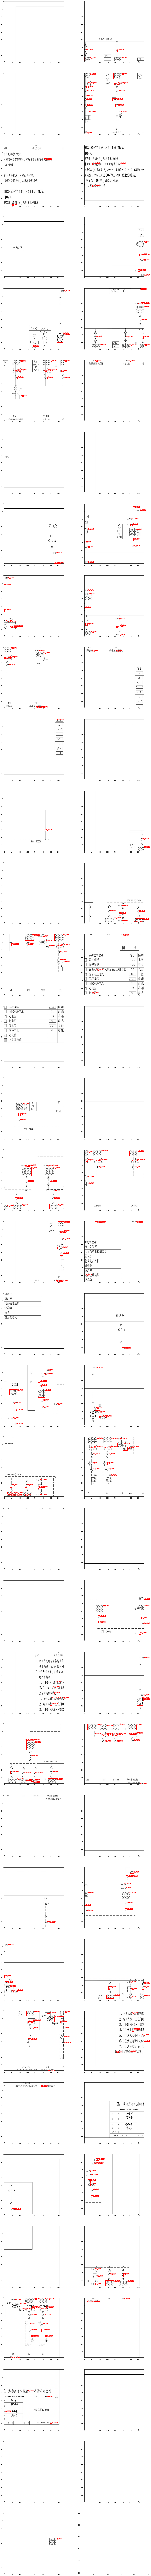

In [29]:
# 预测结果可视化
interpretation.show_batch_pred(imgs,
                               b_boxs,
                               b_cats,
                               b_f1s,
                               classes=predictor.classes)

# export

In [30]:
!python ../../notebook2script.py --fname 'inference.ipynb' --outputDir '../exp/'

Converted inference.ipynb to ../exp/inference.py
